In [1]:
# Standard library imports
from foundational_ssm.utils import h5_to_dict 
import math
import os
import json
import tempfile
import multiprocessing as mp
import logging
import time
import h5py
from functools import partial

# Third-party imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import wandb
import jax
import jax.numpy as jnp
from jax import random as jr
from torch.utils.data import DataLoader
import optax
import equinox as eqx

# Foundational SSM imports
from omegaconf import OmegaConf
from foundational_ssm.loaders import get_brainset_train_val_loaders
from foundational_ssm.utils import load_model_and_state_wandb, save_checkpoint_wandb, load_checkpoint_wandb, transfer_foundational_to_downstream, add_alias_to_checkpoint, load_artifact_with_tempdir
from foundational_ssm.metrics import compute_r2_standard
from foundational_ssm.utils.training import (
    make_step_downstream,
    mse_loss_downstream,
    get_filter_spec,
)
from foundational_ssm.utils.training_utils import (
    log_batch_metrics, track_batch_timing, setup_wandb_metrics
)
from foundational_ssm.samplers import SequentialFixedWindowSampler
from foundational_ssm.collate import pad_collate
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder
from foundational_ssm.transform import smooth_spikes


import multiprocessing as mp

def train_one_batch(batch, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step):
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    
    key, subkey = jr.split(train_key)
    model, state, opt_state, loss_value, grads = make_step_downstream(model, state, inputs, targets, mask, key, filter_spec, loss_fn, opt, opt_state)
    current_lr = lr_scheduler(current_step)
    wandb.log({
        "train/loss": loss_value,
        "train/learning_rate": current_lr,
    }, step=current_step)
    
    return model, state, opt_state, loss_value

def train_one_epoch(train_loader, model, state, rng_key, filter_spec, loss_fn, opt, opt_state, lr_scheduler, current_step, epoch):    
    epoch_loss = 0
    batch_count = 0
    minute_start_time = time.time()
    prev_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader):
        data_load_time = time.time() - prev_time
        batch_process_start = time.time()
        
        model, state, opt_state, loss_value = train_one_batch(
            batch, model, state, filter_spec, loss_fn, opt, opt_state, rng_key, lr_scheduler, current_step
        )
        batch_process_end = time.time()
        batch_process_time = batch_process_end - batch_process_start
        
        log_batch_metrics(data_load_time, batch_process_time, epoch, current_step)
        epoch_loss += loss_value
        batch_count += 1
        current_time = time.time()
        batch_count, minute_start_time = track_batch_timing(batch_count, minute_start_time, current_time, current_step)
        prev_time = time.time()
        current_step += 1
    
    wandb.log({"train/epoch_loss": epoch_loss, "epoch": epoch}, step=current_step)
    return model, state, opt_state, current_step, epoch_loss

def validate_one_epoch(batch, model, state, epoch, current_step, dataset_name):
    logger.info("Validating one epoch")
    metrics = {}  # New: store metrics per group
    all_preds = []
    all_targets = []
    val_start_time = time.time()
    
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    mask = mask[..., None]
    preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, None, None), out_axes=(0, None))(inputs, state, jr.PRNGKey(0), True)
    all_preds.append(jnp.where(mask, preds, 0))
    all_targets.append(jnp.where(mask, targets, 0))

    all_preds = jnp.concatenate(all_preds, axis=0)
    all_targets = jnp.concatenate(all_targets, axis=0)
    
    r2_score = compute_r2_standard(all_preds, all_targets)
    metrics[f'val/r2_{dataset_name}'] = float(r2_score)

    # Log validation timing and resources
    val_end_time = time.time()
    val_time = val_end_time - val_start_time
    metrics[f'val/time_{dataset_name}'] = val_time
    metrics['epoch'] = epoch

    wandb.log(metrics, step=current_step)
    return metrics



def generate_predictions_and_activations(model, state, batch):
    """Generate predictions and activations for a batch"""
    inputs = batch['neural_input']
    targets = batch['behavior_input']
    mask = batch['mask']
    preds, activations_list, state = jax.vmap(model.call_with_activations, axis_name="batch", in_axes=(0, None, None), out_axes=(0, 0, None))(inputs, state, jr.PRNGKey(0))
    activations = {f'ssm_block_{i}': activations_list[i] for i in range(len(activations_list))}
    
    return {
        'predictions': preds,
        'activations': activations,
        'targets': targets,
        'mask': mask,
        'num_trials': inputs.shape[0]
    }
    
def log_predictions_and_activations(model, state, data, cfg, epoch, current_step, run_name, dataset_name):
    """Generate and log predictions and activations as wandb artifact"""
    print(f"[DEBUG] Generating predictions and activations for epoch {epoch}")
    
    # Save to H5 file
    h5_path = f"/cs/student/projects1/ml/2024/mlaimon/{run_name}/predictions_and_activations_epoch_{epoch}.h5"
    os.makedirs(os.path.dirname(h5_path), exist_ok=True)
    session_data = generate_predictions_and_activations(model, state, data)
    
    with h5py.File(h5_path, 'w') as f:
        # Create session group
        sessions_group = f.create_group('sessions')
        session_group = sessions_group.create_group(dataset_name)
        
        # Save predictions
        session_group.create_dataset('predictions', data=session_data['predictions'])
        session_group.create_dataset('targets', data=session_data['targets'])
        session_group.create_dataset('mask', data=session_data['mask'])
        session_group.create_dataset('num_trials', data=session_data['num_trials'])
        
        # Save activations
        activations_group = session_group.create_group('activations')
        for block_name, activation_data in session_data['activations'].items():
            activations_group.create_dataset(block_name, data=activation_data)
    
    # Create and log wandb artifact
    artifact = wandb.Artifact(
        name=f"{run_name}_predictions_and_activations",
        type="predictions_and_activations",
        description=f"Model predictions and activations for epoch {epoch}"
    )
    artifact.add_file(h5_path)
    
    # Add metadata
    artifact.metadata.update({
        'epoch': epoch,
        'current_step': current_step,
        'num_sessions': len(session_data['predictions']),
    })
    
    wandb.log_artifact(artifact, aliases=[f'epoch_{epoch}'])
    print(f"[DEBUG] Logged predictions and activations artifact for epoch {epoch}")
    
    return h5_path

def create_dataloader(data_dict, batch_size, shuffle=True, rng_key=None):
    """
    Creates a generator for minibatches from a dictionary of data.

    Args:
        data_dict (dict): A dictionary where keys are data names (e.g., 'neural_input')
                          and values are arrays of the same leading dimension (samples).
        batch_size (int): The desired size of each minibatch.
        shuffle (bool): Whether to shuffle the data before creating minibatches.
        rng_key (jr.PRNGKey, optional): JAX PRNGKey for shuffling. Required if shuffle is True.

    Yields:
        dict: A dictionary representing a minibatch.
    """
    n_samples = next(iter(data_dict.values())).shape[0]
    indices = jr.permutation(rng_key, n_samples) if shuffle else jr.arange(n_samples)

    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        minibatch = {k: v[batch_indices] for k, v in data_dict.items()}
        yield minibatch

%load_ext autoreload
%autoreload 2

In [ ]:
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/downstream_nlb.yaml"
cfg = OmegaConf.load(config_path) 

# =============================================================
# Load dataset and preprocess
# =============================================================
dataset_name, dataset_path = cfg.datasets.items()[0]
data = h5_to_dict(dataset_path)
data['neural_input'] = smooth_spikes(data['neural_input'], kern_sd_ms=20, bin_size_ms=5, time_axis=1)

# Split the data into training and validation sets
n_samples = data['neural_input'].shape[0]
train_samples = math.ceil(n_samples*0.7)
train_data = {k: v[:train_samples] for k, v in data.items()}
val_data = {k: v[train_samples:] for k, v in data.items()}


# ============================================================
# Set up multiprocessing and WandB API
# ============================================================
mp.set_start_method("spawn", force=True)
tempdir = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/wandb_artifacts"
os.environ['WANDB_CACHE_DIR'] = '/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/wandb_cache'
api = wandb.Api()

best_r2_score = 0
key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)
for name, artifact_full_name in cfg.models.items():
    for ds_mode_name, ds_mode_cfg  in cfg.downstream_modes.items():
        # ===========================================================
        # load_checkpoint 
        # ===========================================================
        artifact = api.artifact(artifact_full_name, type="checkpoint")
        foundational_run = artifact.logged_by()
        foundational_run_cfg = OmegaConf.create(foundational_run.config)
        
        foundational_model = SSMFoundationalDecoder(
                **foundational_run_cfg.model
            )
        
        downstream_model_cfg = foundational_run_cfg.model.copy()
        downstream_model_cfg.update({'input_dim':130})
        downstream_model = SSMDownstreamDecoder(**downstream_model_cfg)


        # ===================================================================================
        #  Load foundational model from checkpoint and transfer SSM layers to downstream
        # ===================================================================================
        if ds_mode_cfg.from_scratch == False:
            with tempfile.TemporaryDirectory() as temp_dir:
                artifact.download(temp_dir)
                
                # Find the checkpoint file in the downloaded directory
                checkpoint_files = [f for f in os.listdir(temp_dir) if f.endswith('.ckpt')]
                if not checkpoint_files:
                    print(f"Available files in {temp_dir}: {os.listdir(temp_dir)}")
                    raise FileNotFoundError(f"No checkpoint file found in {temp_dir}. Available files: {os.listdir(temp_dir)}")
                
                checkpoint_path = os.path.join(temp_dir, checkpoint_files[0])
                print(f"Loading checkpoint from: {checkpoint_path}")
                
                with open(checkpoint_path, 'rb') as f:
                    meta = json.loads(f.readline().decode())
                    foundational_model = eqx.tree_deserialise_leaves(f, foundational_model)
                
            downstream_model = transfer_foundational_to_downstream(foundational_model, downstream_model)
            
        downstream_state = eqx.nn.State(downstream_model)
        
        run_name = f"{cfg.wandb.run_prefix}_{dataset_name}_{ds_mode_name}_l{downstream_model_cfg.ssm_num_layers}_d{downstream_model_cfg.ssm_dim}"
        cfg.update({'downstream_model_cfg': downstream_model_cfg})
        wandb.init(project=cfg.wandb.project, name=run_name, config=dict(cfg)) 
        
        filter_spec = get_filter_spec(
            downstream_model,
            **ds_mode_cfg.filter_spec
        )
        
        lr_scheduler = lambda step: cfg.optimizer.lr
        
        opt = optax.chain(
            optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
        )
        opt_state = opt.init(eqx.filter(downstream_model, filter_spec))
        
        current_step = 0
        
        for epoch in range(0, cfg.training.epochs):
            train_key, subkey = jr.split(train_key)

            # Create a new train_loader for each epoch to ensure fresh shuffling
            train_loader = create_dataloader(train_data, cfg.training.batch_size, shuffle=True, rng_key=subkey)
            epoch_loss = 0.0
            num_batches = 0

            # Iterate through minibatches
            for i, minibatch in enumerate(train_loader):
                batch_train_key, _ = jr.split(train_key) # Generate a new key for each batch
                downstream_model, downstream_state, opt_state, batch_loss = train_one_batch(
                    minibatch, downstream_model, downstream_state, filter_spec,
                    mse_loss_downstream, opt, opt_state, batch_train_key, lr_scheduler, current_step
                )
                epoch_loss += batch_loss
                num_batches += 1
                current_step += 1 # Increment step for each batch

            wandb.log({"train/epoch_loss": epoch_loss}, step=current_step)

            if epoch % cfg.training.checkpoint_every == 0:
                metadata = {
                    'train_loss': epoch_loss
                }
                checkpoint_artifact = save_checkpoint_wandb(downstream_model, downstream_state, opt_state, epoch, current_step, metadata, run_name)

            if epoch % cfg.training.log_val_every == 0:
                add_alias_to_checkpoint(checkpoint_artifact, f'epoch_{epoch}')
                logger.info(f"Running validation for epoch {epoch}")
                metrics = validate_one_epoch(val_batch, downstream_model, downstream_state, epoch, current_step, dataset_name)
                
                # Track best R² score
                current_r2_avg = metrics.get(f'val/r2_{dataset_name}', 0.0)
                if current_r2_avg > best_r2_score:
                    best_r2_score = current_r2_avg
                    logger.info(f"New best R² score: {best_r2_score:.4f} at epoch {epoch}")
                    add_alias_to_checkpoint(checkpoint_artifact, 'best', metrics)
            
            if epoch % cfg.training.log_pred_and_activations_every == 0:
                log_predictions_and_activations(downstream_model, state, data, cfg, epoch, current_step, run_name, dataset_name)
                
        wandb.finish()

INFO:2025-08-02 13:47:37,615:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
wandb: Currently logged in as: melinajingting (melinajingting-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Minibatch GD

In [ ]:
from foundational_ssm.transform import smooth_spikes
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/downstream_nlb.yaml"
cfg = OmegaConf.load(config_path) 
dataset_name = 'rtt'

mp.set_start_method("spawn", force=True)
api = wandb.Api()
logging.basicConfig(filename='downstream_decoding_nlb.log', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
tempdir = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/wandb_artifacts"
os.environ['WANDB_CACHE_DIR'] = '/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/wandb_cache'
best_r2_score = 0



data = h5_to_dict('/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized.h5')
data['neural_input'] = smooth_spikes(data['neural_input'], kern_sd_ms=20, bin_size_ms=5, time_axis=1)
n_samples = data['neural_input'].shape[0]
train_samples = math.ceil(n_samples*0.7)

# Split the data into training and validation sets
train_data = {k: v[:train_samples] for k, v in data.items()}
val_data = {k: v[train_samples:] for k, v in data.items()}

# Define batch size for the training loader
BATCH_SIZE = 16

for name, artifact_full_name in cfg.models.items():
    for ds_mode_name, ds_mode_cfg in cfg.downstream_modes.items():
        key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)
        # ===========================================================
        # load_checkpoint
        # ===========================================================
        artifact = api.artifact(artifact_full_name, type="checkpoint")
        foundational_run = artifact.logged_by()
        foundational_run_cfg = OmegaConf.create(foundational_run.config)

        foundational_model = SSMFoundationalDecoder(
            **foundational_run_cfg.model
        )

        downstream_model_cfg = foundational_run_cfg.model.copy()
        downstream_model_cfg.update({'input_dim': 130})
        downstream_model = SSMDownstreamDecoder(**downstream_model_cfg)

        # ===================================================================================
        #  Load foundational model from checkpoint and transfer SSM layers to downstream
        # ===================================================================================
        if ds_mode_cfg.from_scratch == False:
            with tempfile.TemporaryDirectory() as temp_dir:
                artifact.download(temp_dir)

                # Find the checkpoint file in the downloaded directory
                checkpoint_files = [f for f in os.listdir(temp_dir) if f.endswith('.ckpt')]
                if not checkpoint_files:
                    print(f"Available files in {temp_dir}: {os.listdir(temp_dir)}")
                    raise FileNotFoundError(f"No checkpoint file found in {temp_dir}. Available files: {os.listdir(temp_dir)}")

                checkpoint_path = os.path.join(temp_dir, checkpoint_files[0])
                print(f"Loading checkpoint from: {checkpoint_path}")

                with open(checkpoint_path, 'rb') as f:
                    meta = json.loads(f.readline().decode())
                    foundational_model = eqx.tree_deserialise_leaves(f, foundational_model)

            downstream_model = transfer_foundational_to_downstream(foundational_model, downstream_model)

        downstream_state = eqx.nn.State(downstream_model)

        run_name = f"{dataset_name}_{ds_mode_name}_l{downstream_model_cfg.ssm_num_layers}_d{downstream_model_cfg.ssm_dim}"

        # if run_name == 'mb_rtt_full_l2_d128':
        #     continue
        wandb.init(project=cfg.wandb.project, name=run_name, config=dict(cfg))

        filter_spec = get_filter_spec(
            downstream_model,
            **ds_mode_cfg.filter_spec
        )

        lr_scheduler = lambda step: cfg.optimizer.lr

        opt = optax.chain(
            optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
        )
        opt_state = opt.init(eqx.filter(downstream_model, filter_spec))

        current_step = 0

        for epoch in range(0, cfg.training.epochs):
            train_key, subkey = jr.split(train_key)
            logger.info(f"Running training for epoch {epoch}")

            # Create a new train_loader for each epoch to ensure fresh shuffling
            train_loader = create_dataloader(train_data, BATCH_SIZE, shuffle=True, rng_key=subkey)
            epoch_loss = 0.0
            num_batches = 0

            # Iterate through minibatches
            for i, minibatch in enumerate(train_loader):
                batch_train_key, _ = jr.split(train_key) # Generate a new key for each batch
                downstream_model, downstream_state, opt_state, batch_loss = train_one_batch(
                    minibatch, downstream_model, downstream_state, filter_spec,
                    mse_loss_downstream, opt, opt_state, batch_train_key, lr_scheduler, current_step
                )
                epoch_loss += batch_loss
                num_batches += 1
                current_step += 1 # Increment step for each batch

            wandb.log({"train/epoch_loss": epoch_loss}, step=current_step)


            if epoch % cfg.training.checkpoint_every == 0:
                metadata = {
                    'train_loss': epoch_loss
                }
                logger.info(f"Saving checkpoint for epoch {epoch}")
                checkpoint_artifact = save_checkpoint_wandb(downstream_model, downstream_state, opt_state, epoch, current_step, metadata, run_name)

            if epoch % cfg.training.log_val_every == 0:
                add_alias_to_checkpoint(checkpoint_artifact, f'epoch_{epoch}')
                logger.info(f"Running validation for epoch {epoch}")
                metrics = validate_one_epoch(val_data, downstream_model, downstream_state, epoch, current_step, dataset_name)

                # Track best R² score
                current_r2_avg = metrics.get(f'val/r2_{dataset_name}', 0.0)
                if current_r2_avg > best_r2_score:
                    best_r2_score = current_r2_avg
                    logger.info(f"New best R² score: {best_r2_score:.4f} at epoch {epoch}")
                    add_alias_to_checkpoint(checkpoint_artifact, 'best', metrics)

            if epoch % cfg.training.log_pred_and_activations_every == 0:
                # For logging predictions and activations, usually done on the full dataset or a representative subset
                log_predictions_and_activations(downstream_model, downstream_state, data, cfg, epoch, current_step, run_name, dataset_name)

        wandb.finish()

/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


No previous checkpoint to delete or deletion failed: 404 Client Error: Not Found for url: https://api.wandb.ai/graphql
Saved checkpoint at epoch 0
[DEBUG] Generating predictions and activations for epoch 0
[DEBUG] Logged predictions and activations artifact for epoch 0
Saved checkpoint at epoch 50
Saved checkpoint at epoch 100
[DEBUG] Generating predictions and activations for epoch 100
[DEBUG] Logged predictions and activations artifact for epoch 100
Saved checkpoint at epoch 150
Saved checkpoint at epoch 200
[DEBUG] Generating predictions and activations for epoch 200
[DEBUG] Logged predictions and activations artifact for epoch 200
Saved checkpoint at epoch 250
Saved checkpoint at epoch 300
[DEBUG] Generating predictions and activations for epoch 300
[DEBUG] Logged predictions and activations artifact for epoch 300
Saved checkpoint at epoch 350
Saved checkpoint at epoch 400
[DEBUG] Generating predictions and activations for epoch 400
[DEBUG] Logged predictions and activations artifa

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▃▃▄▅▆▆▇█
train/epoch_loss,█▇▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val/r2_rtt,▁█████████
val/time_rtt,▄█▆█▁▃▃▂▃▆
epoch,900
train/epoch_loss,233.5251
train/learning_rate,0.001
train/loss,9.03548
val/r2_rtt,0.70363


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


No previous checkpoint to delete or deletion failed: 404 Client Error: Not Found for url: https://api.wandb.ai/graphql
Saved checkpoint at epoch 0
[DEBUG] Generating predictions and activations for epoch 0
[DEBUG] Logged predictions and activations artifact for epoch 0
Saved checkpoint at epoch 50
Saved checkpoint at epoch 100
[DEBUG] Generating predictions and activations for epoch 100
[DEBUG] Logged predictions and activations artifact for epoch 100
Saved checkpoint at epoch 150
Saved checkpoint at epoch 200
[DEBUG] Generating predictions and activations for epoch 200
[DEBUG] Logged predictions and activations artifact for epoch 200
Saved checkpoint at epoch 250
Saved checkpoint at epoch 300
[DEBUG] Generating predictions and activations for epoch 300
[DEBUG] Logged predictions and activations artifact for epoch 300
Saved checkpoint at epoch 350
Saved checkpoint at epoch 400
[DEBUG] Generating predictions and activations for epoch 400
[DEBUG] Logged predictions and activations artifa

KeyboardInterrupt: 

# Original Splits

In [3]:
from foundational_ssm.transform import smooth_spikes
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/downstream_nlb.yaml"
cfg = OmegaConf.load(config_path) 
dataset_name = 'rtt_nlb_split'

mp.set_start_method("spawn", force=True)
api = wandb.Api()
logging.basicConfig(filename='downstream_decoding_nlb.log', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
tempdir = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/wandb_artifacts"
os.environ['WANDB_CACHE_DIR'] = '/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/wandb_cache'
best_r2_score = 0


train_data = h5_to_dict('/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_not_trialized_train.h5')
train_data['neural_input'] = smooth_spikes(train_data['neural_input'], kern_sd_ms=20, bin_size_ms=5, time_axis=1)
val_data = h5_to_dict('/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_not_trialized_val.h5')
val_data['neural_input'] = smooth_spikes(val_data['neural_input'], kern_sd_ms=20, bin_size_ms=5, time_axis=1)


# Define batch size for the training loader
BATCH_SIZE = 16

for name, artifact_full_name in cfg.models.items():
    for ds_mode_name, ds_mode_cfg in cfg.downstream_modes.items():
        key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)
        # ===========================================================
        # load_checkpoint
        # ===========================================================
        artifact = api.artifact(artifact_full_name, type="checkpoint")
        foundational_run = artifact.logged_by()
        foundational_run_cfg = OmegaConf.create(foundational_run.config)

        foundational_model = SSMFoundationalDecoder(
            **foundational_run_cfg.model
        )

        downstream_model_cfg = foundational_run_cfg.model.copy()
        downstream_model_cfg.update({'input_dim': 130})
        downstream_model = SSMDownstreamDecoder(**downstream_model_cfg)

        # ===================================================================================
        #  Load foundational model from checkpoint and transfer SSM layers to downstream
        # ===================================================================================
        if ds_mode_cfg.from_scratch == False:
            with tempfile.TemporaryDirectory() as temp_dir:
                artifact.download(temp_dir)

                # Find the checkpoint file in the downloaded directory
                checkpoint_files = [f for f in os.listdir(temp_dir) if f.endswith('.ckpt')]
                if not checkpoint_files:
                    print(f"Available files in {temp_dir}: {os.listdir(temp_dir)}")
                    raise FileNotFoundError(f"No checkpoint file found in {temp_dir}. Available files: {os.listdir(temp_dir)}")

                checkpoint_path = os.path.join(temp_dir, checkpoint_files[0])
                print(f"Loading checkpoint from: {checkpoint_path}")

                with open(checkpoint_path, 'rb') as f:
                    meta = json.loads(f.readline().decode())
                    foundational_model = eqx.tree_deserialise_leaves(f, foundational_model)

            downstream_model = transfer_foundational_to_downstream(foundational_model, downstream_model)

        downstream_state = eqx.nn.State(downstream_model)

        run_name = f"smthspk_{dataset_name}_{ds_mode_name}_l{downstream_model_cfg.ssm_num_layers}_d{downstream_model_cfg.ssm_dim}"

        # if run_name == 'mb_rtt_full_l2_d128':
        #     continue
        wandb.init(project=cfg.wandb.project, name=run_name, config=dict(cfg))

        filter_spec = get_filter_spec(
            downstream_model,
            **ds_mode_cfg.filter_spec
        )

        lr_scheduler = lambda step: cfg.optimizer.lr

        opt = optax.chain(
            optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
        )
        opt_state = opt.init(eqx.filter(downstream_model, filter_spec))

        current_step = 0

        for epoch in range(0, cfg.training.epochs):
            train_key, subkey = jr.split(train_key)
            logger.info(f"Running training for epoch {epoch}")

            # Create a new train_loader for each epoch to ensure fresh shuffling
            train_loader = create_dataloader(train_data, BATCH_SIZE, shuffle=True, rng_key=subkey)
            epoch_loss = 0.0
            num_batches = 0

            # Iterate through minibatches
            for i, minibatch in enumerate(train_loader):
                batch_train_key, _ = jr.split(train_key) # Generate a new key for each batch
                downstream_model, downstream_state, opt_state, batch_loss = train_one_batch(
                    minibatch, downstream_model, downstream_state, filter_spec,
                    mse_loss_downstream, opt, opt_state, batch_train_key, lr_scheduler, current_step
                )
                epoch_loss += batch_loss
                num_batches += 1
                current_step += 1 # Increment step for each batch

            wandb.log({"train/epoch_loss": epoch_loss}, step=current_step)


            if epoch % cfg.training.checkpoint_every == 0:
                metadata = {
                    'train_loss': epoch_loss
                }
                logger.info(f"Saving checkpoint for epoch {epoch}")
                checkpoint_artifact = save_checkpoint_wandb(downstream_model, downstream_state, opt_state, epoch, current_step, metadata, run_name)

            if epoch % cfg.training.log_val_every == 0:
                add_alias_to_checkpoint(checkpoint_artifact, f'epoch_{epoch}')
                logger.info(f"Running validation for epoch {epoch}")
                metrics = validate_one_epoch(val_data, downstream_model, downstream_state, epoch, current_step, dataset_name)

                # Track best R² score
                current_r2_avg = metrics.get(f'val/r2_{dataset_name}', 0.0)
                if current_r2_avg > best_r2_score:
                    best_r2_score = current_r2_avg
                    logger.info(f"New best R² score: {best_r2_score:.4f} at epoch {epoch}")
                    add_alias_to_checkpoint(checkpoint_artifact, 'best', metrics)

            # if epoch % cfg.training.log_pred_and_activations_every == 0:
            #     # For logging predictions and activations, usually done on the full dataset or a representative subset
            #     log_predictions_and_activations(downstream_model, downstream_state, data, cfg, epoch, current_step, run_name, dataset_name)

        wandb.finish()

INFO:2025-07-30 22:51:46,915:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
wandb: Currently logged in as: melinajingting (melinajingting-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Saved checkpoint at epoch 0
Saved checkpoint at epoch 100
Saved checkpoint at epoch 200
Saved checkpoint at epoch 300
Saved checkpoint at epoch 400
Saved checkpoint at epoch 500
Saved checkpoint at epoch 600
Saved checkpoint at epoch 700
Saved checkpoint at epoch 800
Saved checkpoint at epoch 900


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▃▃▄▅▆▆▇█
train/epoch_loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▅▇▆█▅▆▄▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/r2_rtt_nlb_split,▁▇▇▇▇█████
val/time_rtt_nlb_split,█▁▁▁▁▁▁▁▁▁
epoch,900
train/epoch_loss,3052.41602
train/learning_rate,0.001
train/loss,36.85061
val/r2_rtt_nlb_split,0.49239


wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmp8v3ryfsm/tmpe9qkrek7.ckpt


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Saved checkpoint at epoch 0
Saved checkpoint at epoch 100
Saved checkpoint at epoch 200
Saved checkpoint at epoch 300
Saved checkpoint at epoch 400
Saved checkpoint at epoch 500
Saved checkpoint at epoch 600
Saved checkpoint at epoch 700
Saved checkpoint at epoch 800
Saved checkpoint at epoch 900


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▃▃▄▅▆▆▇█
train/epoch_loss,█▇▆▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▅▄▆▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val/r2_rtt_nlb_split,▁█████████
val/time_rtt_nlb_split,▂▃▁▂▁▁▂▃█▄
epoch,900
train/epoch_loss,4536.62842
train/learning_rate,0.001
train/loss,47.13639
val/r2_rtt_nlb_split,0.49959


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


No previous checkpoint to delete or deletion failed: 404 Client Error: Not Found for url: https://api.wandb.ai/graphql
Saved checkpoint at epoch 0
Saved checkpoint at epoch 100
Saved checkpoint at epoch 200
Saved checkpoint at epoch 300
Saved checkpoint at epoch 400
Saved checkpoint at epoch 500
Saved checkpoint at epoch 600
Saved checkpoint at epoch 700
Saved checkpoint at epoch 800
Saved checkpoint at epoch 900


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▃▃▄▅▆▆▇█
train/epoch_loss,██▅▄▃▃▃▃▂▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/r2_rtt_nlb_split,▁▇███▇████
val/time_rtt_nlb_split,▄▃▃▆▃▅█▂▁▂
epoch,900
train/epoch_loss,1423.6908
train/learning_rate,0.001
train/loss,14.25826
val/r2_rtt_nlb_split,0.5114


wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmpq7z4clqg/tmp5v21z_n6.ckpt


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


No previous checkpoint to delete or deletion failed: 404 Client Error: Not Found for url: https://api.wandb.ai/graphql
Saved checkpoint at epoch 0
Saved checkpoint at epoch 100
Saved checkpoint at epoch 200
Saved checkpoint at epoch 300
Saved checkpoint at epoch 400
Saved checkpoint at epoch 500
Saved checkpoint at epoch 600
Saved checkpoint at epoch 700
Saved checkpoint at epoch 800
Saved checkpoint at epoch 900


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▃▃▄▅▆▆▇█
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▆█▄▃▃▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/r2_rtt_nlb_split,▁█████████
val/time_rtt_nlb_split,▆▆▁█▅▄▂▁▃▅
epoch,900
train/epoch_loss,1759.8363
train/learning_rate,0.001
train/loss,25.18937
val/r2_rtt_nlb_split,0.49644


In [3]:
def load_artifact_with_tempdir(artifact_name, artifact_type='predictions_and_activations'):
    """Load a wandb artifact using a temporary directory and convert to dict
    
    Parameters
    ----------
    artifact_name : str
        Full artifact name (e.g., 'melinajingting-ucl/foundational_ssm_pretrain_decoding/possm_dataset_l1_d64_predictions_and_activations_epoch_300:v0')
    artifact_type : str
        Type of artifact to load
    
    Returns
    -------
    dict
        Dictionary containing the artifact data
    """
    if wandb.run is None:
        wandb.init()
    
    artifact = wandb.run.use_artifact(artifact_name, type=artifact_type)
    
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact_dir = artifact.download(temp_dir)
        
        h5_files = [f for f in os.listdir(temp_dir) if f.endswith('.h5')]
        if not h5_files:
            print(f"Available files in {temp_dir}: {os.listdir(temp_dir)}")
            raise FileNotFoundError(f"No H5 file found in {temp_dir}. Available files: {os.listdir(temp_dir)}")
        
        h5_path = os.path.join(temp_dir, h5_files[0])
        
        with h5py.File(h5_path, 'r') as h5obj:
            data_dict = h5_to_dict(h5obj)
        
        return data_dict

wandb: Downloading large artifact mb_rtt_full_l2_d128_predictions_and_activations:v9, 383.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (819.3MB/s)
wandb: Downloading large artifact mb_rtt_scratch_l2_d128_predictions_and_activations:v9, 383.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (666.3MB/s)
wandb: Downloading large artifact smthspk_rtt_full_l2_d128_predictions_and_activations:v19, 383.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (692.7MB/s)
wandb: Downloading large artifact smthspk_rtt_scratch_l2_d128_predictions_and_activations:v9, 383.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (819.8MB/s)


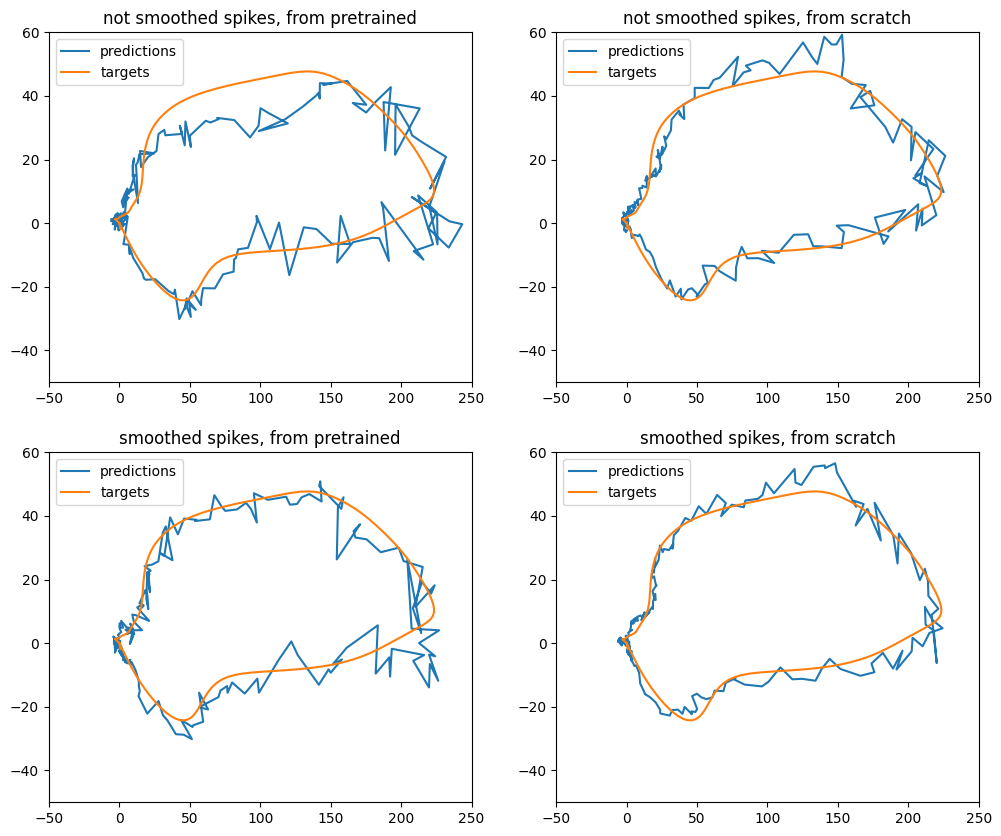

In [7]:
import matplotlib.pyplot as plt
trial_id = 0
to_plot = {
        'not smoothed spikes, from pretrained':'mb_rtt_full_l2_d128_predictions_and_activations:v9',
        'not smoothed spikes, from scratch':'mb_rtt_scratch_l2_d128_predictions_and_activations:v9',
        'smoothed spikes, from pretrained':'smthspk_rtt_full_l2_d128_predictions_and_activations:v19',
        'smoothed spikes, from scratch':'smthspk_rtt_scratch_l2_d128_predictions_and_activations:v9',

           }

fig, axs = plt.subplots(2,2, figsize=(12,10))
axs = axs.flatten()
for i, (title, artifact_name) in enumerate(to_plot.items()):
    ax = axs[i]
    spksmth_artifact = load_artifact_with_tempdir(f'melinajingting-ucl/foundational_ssm_downstream_decoding/{artifact_name}')
    session_data = spksmth_artifact['sessions']['rtt']
    ax.plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions')
    ax.plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets')
    ax.legend()
    ax.set_title(title)
    ax.set_ylim(-50,60)
    ax.set_xlim(-50,250)

wandb: Downloading large artifact mb_rtt_full_l2_d128_predictions_and_activations:v9, 383.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6 (666.8MB/s)


Text(0.5, 1.0, 'trial 0, smoothed spikes inputs')

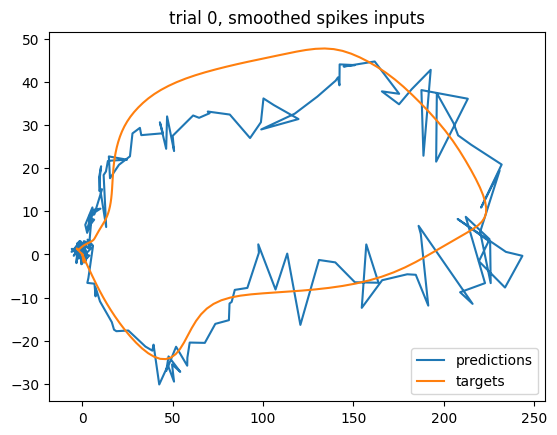

In [ ]:
trial_id = 0
spksmth_artifact = load_artifact_with_tempdir('melinajingting-ucl/foundational_ssm_downstream_decoding/mb_rtt_full_l2_d128_predictions_and_activations:v9')
session_data = spksmth_artifact['sessions']['rtt']
plt.plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions')
plt.plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets')
plt.legend()
plt.title(f'trial {trial_id}, smoothed spikes inputs')

In [ ]:
trial_id = 0
spksmth_artifact = load_artifact_with_tempdir('melinajingting-ucl/foundational_ssm_downstream_decoding/mb_rtt_full_l2_d128_predictions_and_activations:v9')
session_data = spksmth_artifact['sessions']['rtt']
plt.plot(data['neural_input'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions')
plt.plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions')
plt.plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets')
plt.legend()
plt.title(f'trial {trial_id}, smoothed spikes inputs')

wandb: Downloading large artifact rtt_full_l2_d128_predictions_and_activations:v9, 383.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:6.6 (57.7MB/s)


Text(0.5, 1.0, 'trial 4')

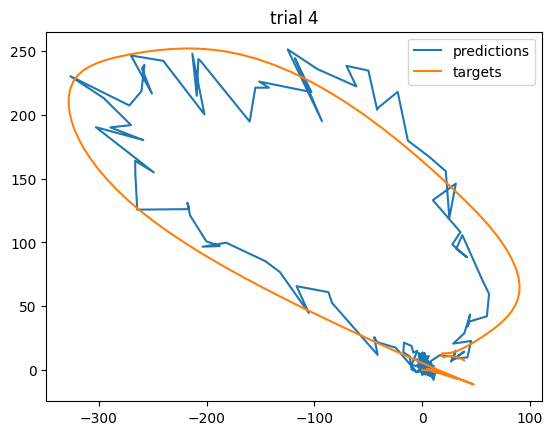

In [ ]:
trial_id = 0
spksmth_artifact = load_artifact_with_tempdir('melinajingting-ucl/foundational_ssm_downstream_decoding/mb_rtt_full_l2_d128_predictions_and_activations:v9')
session_data = spksmth_artifact['sessions']['rtt']
plt.plot(session_data['predictions'][trial_id,:,0], session_data['predictions'][trial_id,:,1], label='predictions')
plt.plot(session_data['targets'][trial_id,:,0], session_data['targets'][trial_id,:,1], label='targets')
plt.legend()
plt.title(f'trial {trial_id}, smoothed spikes inputs')

In [44]:
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/downstream_nlb.yaml"
cfg = OmegaConf.load(config_path) 
artifact_full_name = 'melinajingting-ucl/foundational_ssm_pretrain_decoding/inverse_variance_l2_d128_checkpoint:best'
key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)
# ===========================================================
# load_checkpoint
# ===========================================================
api = wandb.Api()
artifact = api.artifact(artifact_full_name, type="checkpoint")
foundational_run = artifact.logged_by()
foundational_run_cfg = OmegaConf.create(foundational_run.config)

foundational_model = SSMFoundationalDecoder(
    **foundational_run_cfg.model
)

downstream_model_cfg = foundational_run_cfg.model.copy()
downstream_model_cfg.update({'input_dim': 130})
downstream_model = SSMDownstreamDecoder(**downstream_model_cfg)
downstream_state = eqx.nn.State(downstream_model)

ds_mode_cfg = cfg.downstream_modes.full
filter_spec = get_filter_spec(
    downstream_model,
    **ds_mode_cfg.filter_spec
)

lr_scheduler = lambda step: cfg.optimizer.lr

opt = optax.chain(
    optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
)
opt_state = opt.init(eqx.filter(downstream_model, filter_spec))
# downstream_model, downstream_state, opt_state, current_epoch, current_step, meta =load_checkpoint_wandb('', downstream_model, downstream_state, opt_state, filter_spec, 'smthspk_rtt_full_l2_d128', 'foundational_ssm_downstream_decoding', 'melinajingting-ucl')

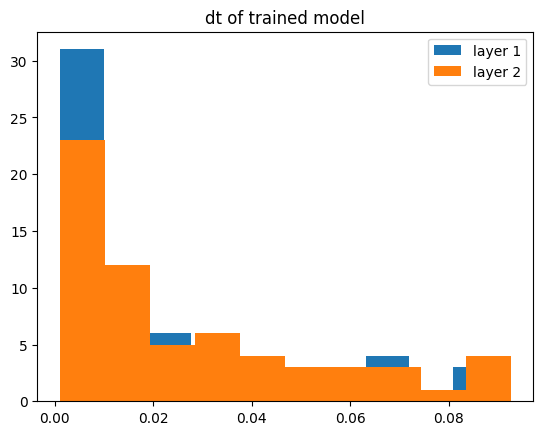

In [45]:
import matplotlib.pyplot as plt
plt.hist(np.exp(downstream_model.ssm_blocks[0].ssm.log_step), label='layer 1')
plt.hist(np.exp(downstream_model.ssm_blocks[1].ssm.log_step), label='layer 2')
plt.title('dt of trained model')
plt.legend()

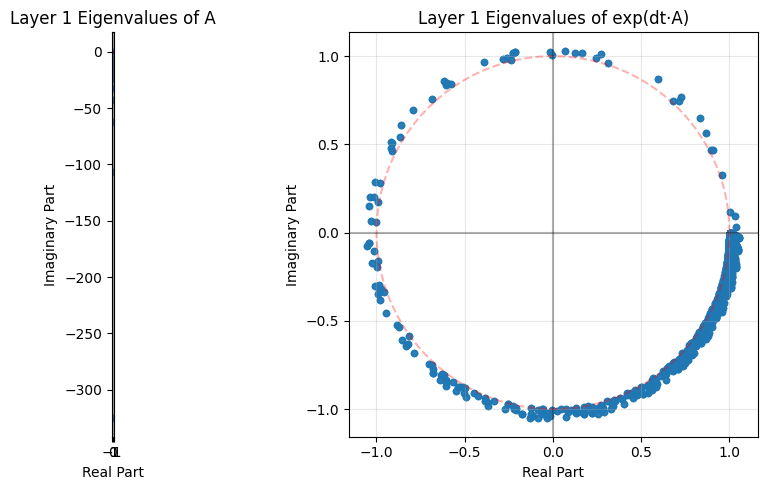

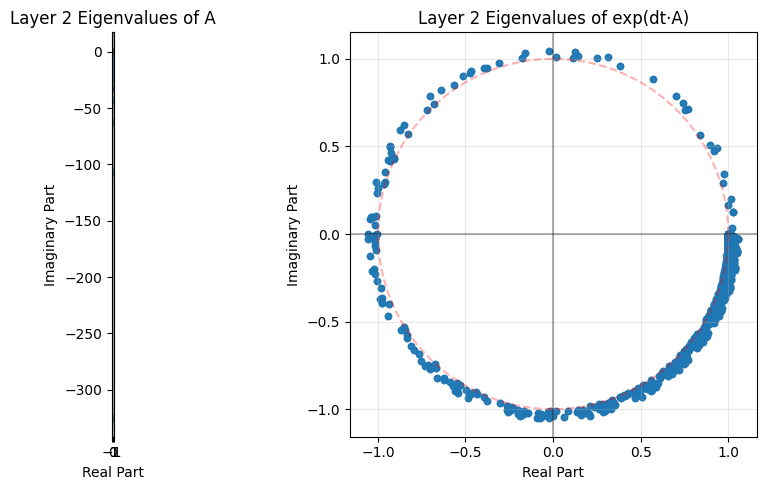

In [46]:
def plot_eigenvalues(kernel, title_prefix="Eigenvalues"):
    A_real = np.exp(kernel.Lambda_re)
    A_imag = kernel.Lambda_im
    A = A_real + 1j *A_imag
    dt = np.exp(kernel.log_step)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    eigenvalues_exp = np.exp(dt * A)
    
    # Plot eigenvalues of A
    sc1 = axs[0].scatter(A_real, A_imag, 
                    alpha=0.5, s=20)
    
    sc2 = axs[1].scatter(np.real(eigenvalues_exp), np.imag(eigenvalues_exp), 
                    alpha=0.5, s=20)
    
    # Plot unit circle 
    for ax, title_suffix in zip(axs, ["of A", "of exp(dt·A)"]):
        theta = np.linspace(0, 2*np.pi, 100)
        ax.plot(np.cos(theta), np.sin(theta), 'r--', alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
        ax.set_xlabel("Real Part")
        ax.set_ylabel("Imaginary Part")
        ax.set_title(f"{title_prefix} {title_suffix}")
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    
    plt.tight_layout()
    plt.show()
    
plot_eigenvalues(downstream_model.ssm_blocks[0].ssm, 'Layer 1 Eigenvalues')
plot_eigenvalues(downstream_model.ssm_blocks[1].ssm, 'Layer 2 Eigenvalues')


# Time series of neural data and activations

wandb: Downloading large artifact smthspk_rtt_full_l2_d128_predictions_and_activations:v19, 383.19MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5 (833.6MB/s)


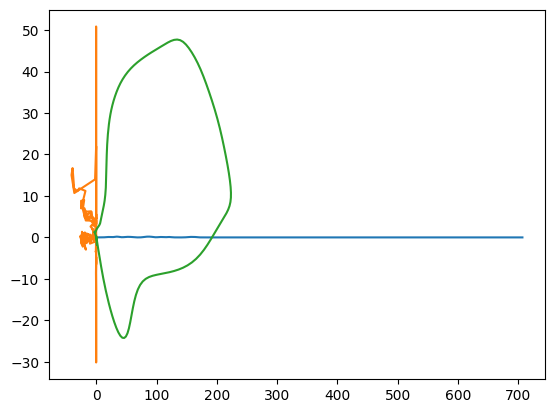

In [ ]:
data = h5_to_dict('/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized.h5')
data['neural_input'] = smooth_spikes(data['neural_input'], kern_sd_ms=20, bin_size_ms=5, time_axis=1)
n_samples = data['neural_input'].shape[0]
train_samples = math.ceil(n_samples*0.7)
trial_id=0

spksmth_artifact = load_artifact_with_tempdir('melinajingting-ucl/foundational_ssm_downstream_decoding/smthspk_rtt_full_l2_d128_predictions_and_activations:v19')
session_data = spksmth_artifact['sessions']['rtt']


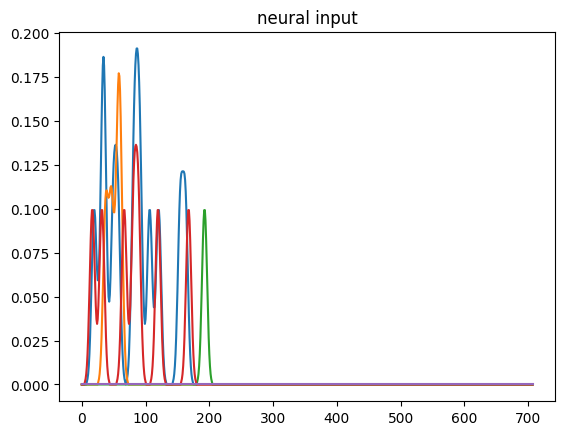

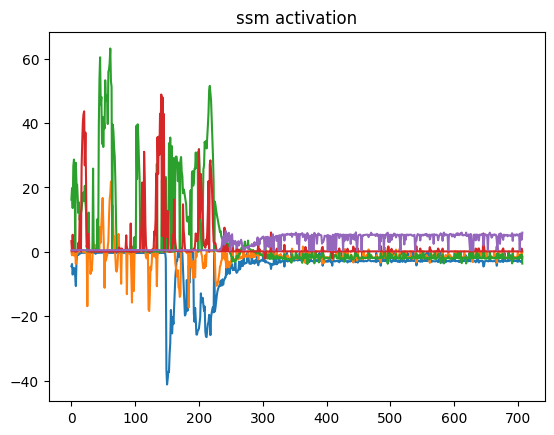

In [56]:
for i in range(5):
    plt.plot(data['neural_input'][trial_id,:,i],label='input')
plt.title('neural input')
plt.show()

for i in range(5):
    plt.plot(session_data['activations']['ssm_block_0'][trial_id,:,i],label='predictions')
plt.title('ssm activation')
plt.show()
